# Atomap tutorial: finding and analysing sublattices

For more details see the open access article: **Atomap: a new software tool for the automated analysis of atomic resolution images using two-dimensional Gaussian fitting**. https://dx.doi.org/10.1186/s40679-017-0042-5

This tutorial shows how to use Atomap to analyse the atomic structure of a perovskite oxide structure, by manually finding the two sublattices in an image.

More documentation is found at http://atomap.org/

*Authorship history*:

- Apr 4, 2017 - Original Notebook written by [Magnus Nord](https://www.ntnu.edu/employees/magnus.nord)
- Oct 9, 2017 - Updates by Ida Hjorth
- Feb 24, 2020 - Further updates by Magnus Nord
- Jul 23, 2022 - Update documentation by Joshua Taillon

## Importing the libraries

Firstly, we must set the plotting toolkit:

In [2]:
%matplotlib notebook

Atomap relies heavily on HyperSpy for visualization and fitting, and uses HyperSpy signals for most of the outputs. So we need to import both HyperSpy and Atomap.

You might get a "WARNING:hyperspy_gui_traitsui", this can be ignored.

In [3]:
# import hyperspy and atomap
import hyperspy.api as hs

In [4]:
import atomap.api as am

### Loading data

Atomap uses HyperSpy signals as its input, which can be any loaded from many different types of files. DM3/DM4, tif, emi/ser, jpg or HDF5-files. This can be loaded using `s = hs.load(your_filename)`.

Here we will be using a test dataset, generated by the `dummy_data` module.

In [5]:
# get the "fantasite" dummy data set
s = am.dummy_data.get_fantasite()

This is an imaginary structure, similar to a perovskite oxide projected along on the [110] direction.

<IPython.core.display.Javascript object>


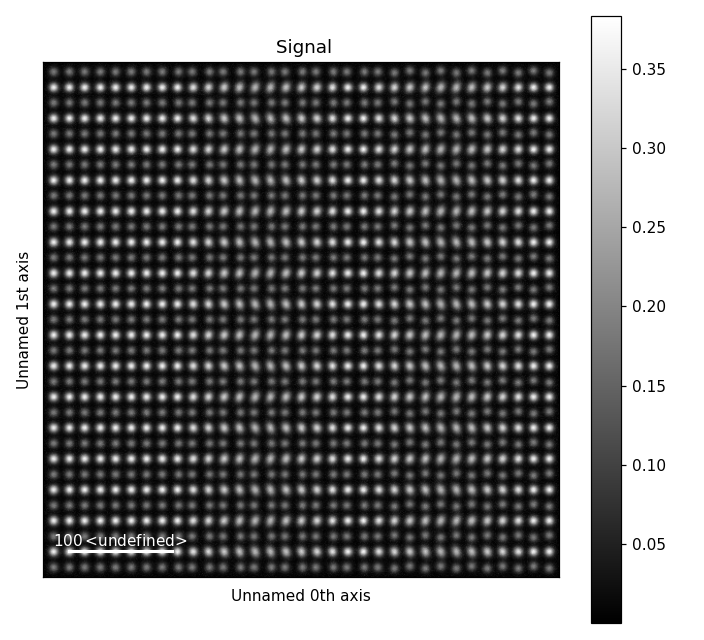

In [6]:
# plot the fantasite image
s.plot()

## Finding initial positions

Our first task is finding and fitting the most intense atomic columns. This is done by using a peak finder, where the minimum distance between the features is used as an input parameter. This function returns a HyperSpy signal, where the atom positions are saved as permanent markers in the metadata

In [7]:
# get the separation between the most intense columns
s_peaks = am.get_feature_separation(s, pca=True)

  0%|          | 0/25 [00:00<?, ?it/s]

[########################################] | 100% Completed |  0.1s


  0%|          | 0/1089 [00:00<?, ?it/s]

In this plot, the minimum feature separation is shown on the x-axis for the navigation plot. This parameter can be changed by using the arrow keys. For this image, we want to get the peaks for only the most intense atomic columns.
A feature separation of 12 works fine.

<IPython.core.display.Javascript object>


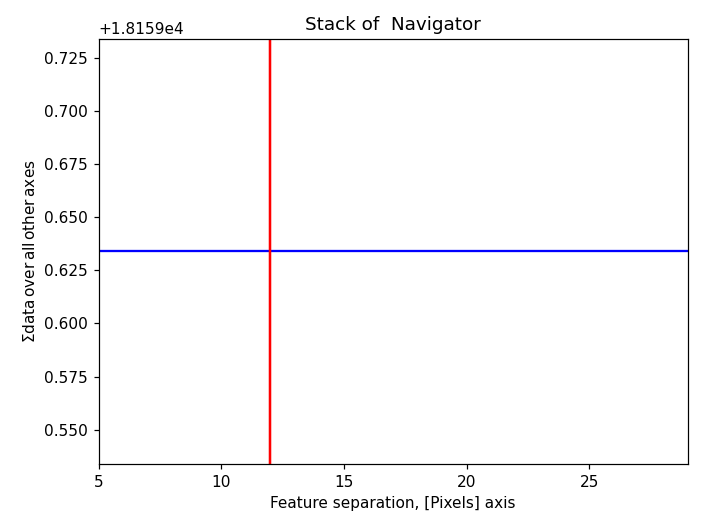

<IPython.core.display.Javascript object>


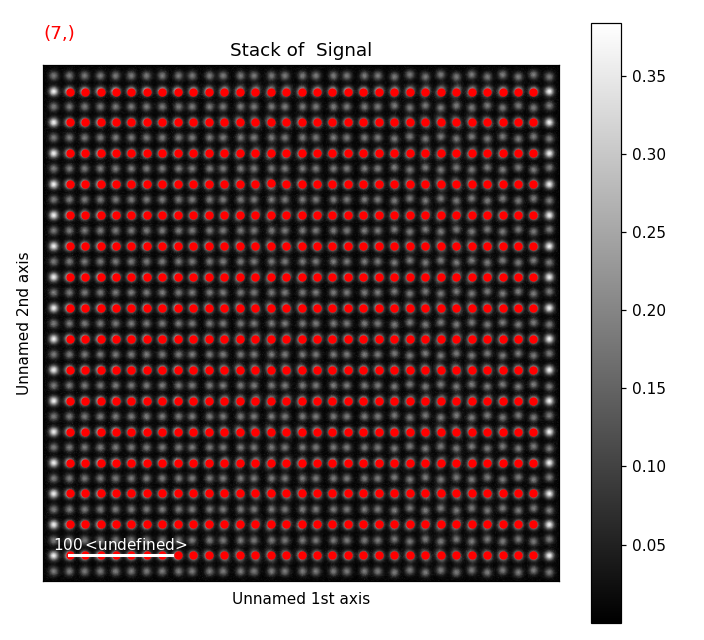

In [8]:
# plot the result of the peak finding (may be a bit slow to render)
s_peaks.plot()

We use this value as an input for the next step, which involves getting these atomic positions as a list.

In [9]:
# get the atomic positions as a list
atom_positions = am.get_atom_positions(s, separation=12, pca=True)

To add or remove atoms, use `add_atoms_with_gui`. Any changes will automatically be updated in the output list `atom_positions_manual`.

<IPython.core.display.Javascript object>


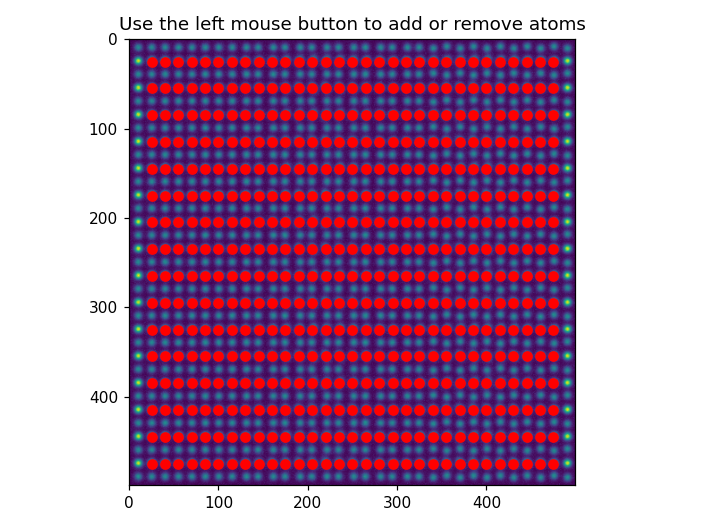

In [10]:
# demonstrate manually adding/removing atoms from list
atom_positions_manual = am.add_atoms_with_gui(s, atom_positions)

## Making a sublattice

The atom positions are used to initialize the sublattice object.

In [11]:
# create a "SubLattice" object
sublattice = am.Sublattice(atom_position_list=atom_positions_manual, image=s.data)

This sublattice object contains the atom positions we just found, the image, and many utility functions. For example a plot function.

<IPython.core.display.Javascript object>


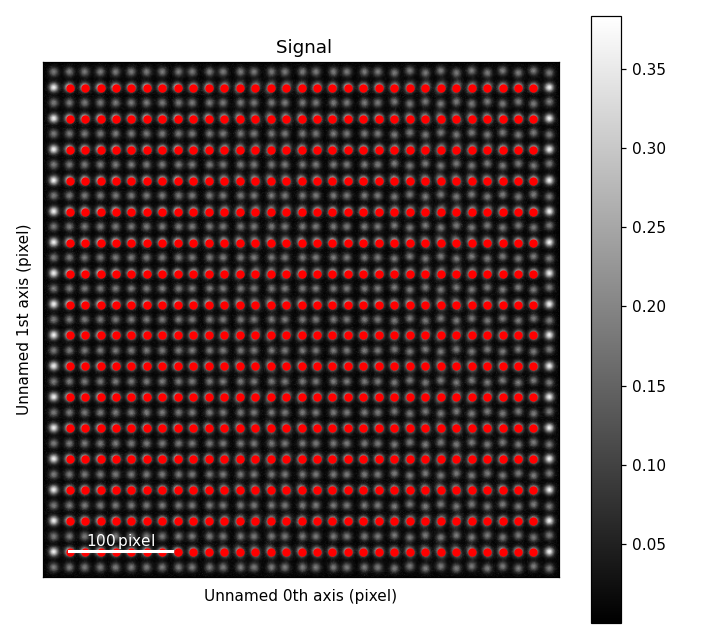

In [12]:
# plot the sublattice
sublattice.plot()

The first step is to refine the atomic positions using center of mass, since the initial atom positions are not very good.

In [13]:
# refine atomic positions by finding nearest neighbors and using their center of mass
sublattice.find_nearest_neighbors()
sublattice.refine_atom_positions_using_center_of_mass()

Center of mass:   0%|          | 0/496 [00:00<?, ?it/s]

Then using 2D Gaussians

In [14]:
# Finally refine using a 2D Gaussian model fit
sublattice.refine_atom_positions_using_2d_gaussian()

Gaussian fitting:   0%|          | 0/496 [00:00<?, ?it/s]

This will give much more accurate atomic positions:

<IPython.core.display.Javascript object>


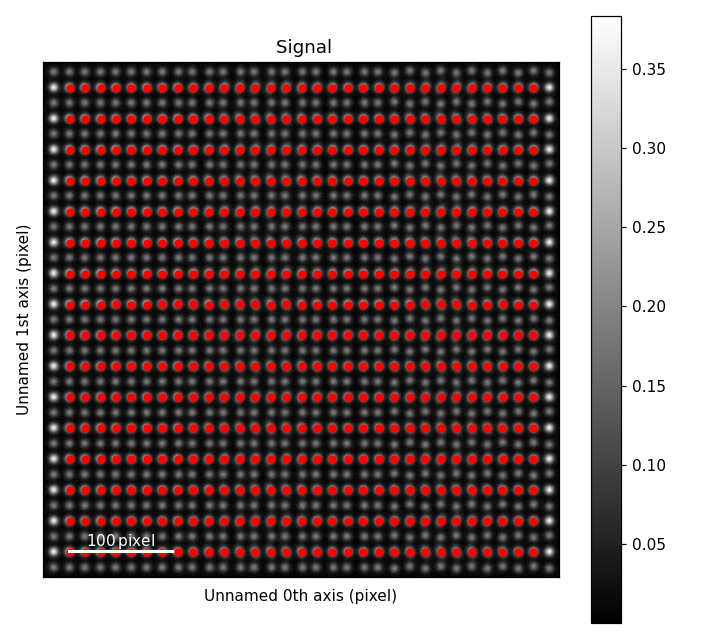

In [15]:
# plot the refined sublattice
sublattice.plot()

## Constructing zone axes

The next step is to find the relation between the atom positions, by ordering them into atomic planes:

In [16]:
# order atomic positions into planes (zone axes)
sublattice.construct_zone_axes()

These atomic planes can be visualized. Navigate using the arrow keys. The number to the top left is the direction of the zone axis.

<IPython.core.display.Javascript object>


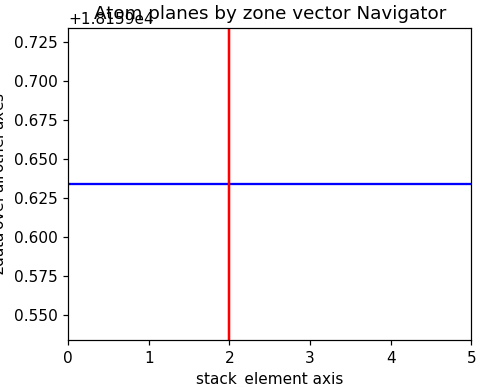

<IPython.core.display.Javascript object>


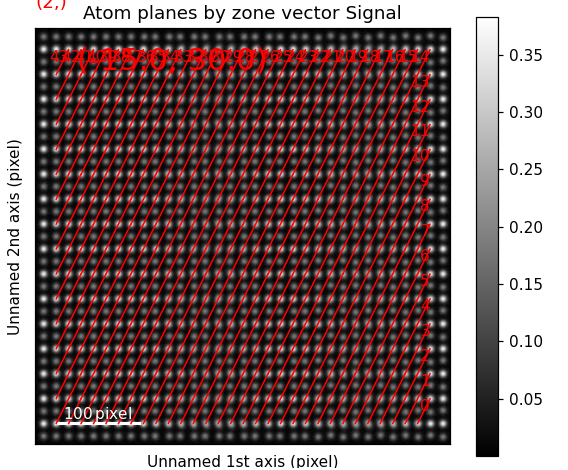

In [17]:
# plot the sublattice planes
sublattice.plot_planes()

## Finding the second sublattice

In this structure, we have two separate sublattices. Having found the first one, we can use those atomic positions to find the second one. Here we use the fact that the atoms in the second sublattice is located between the atoms in the second zone axis for the first sublattice.

In [18]:
# get the average distance between atoms
zone_axis_001 = sublattice.zones_axis_average_distances[1]
zone_axis_001

(-0.0, 30.0)

Then we pass this to the `find_missing_atoms_from_zone_vector`, which returns a new list of positions

In [19]:
# pass theses positions to find the remaining atoms that make up the second sublattice
positions2 = sublattice.find_missing_atoms_from_zone_vector(zone_axis_001)

Secondly, we "subtract" the intensity of the `sublattice` atoms from the fantasite image

In [20]:
# subtract the intensity of the first sublattice from the image to make visualiazation/peak finding easier
from atomap.tools import remove_atoms_from_image_using_2d_gaussian
image_atoms_subtracted = remove_atoms_from_image_using_2d_gaussian(sublattice.image, sublattice)

Subtracting atoms:   0%|          | 0/496 [00:00<?, ?it/s]

Which we use to make the second sublattice:

<IPython.core.display.Javascript object>


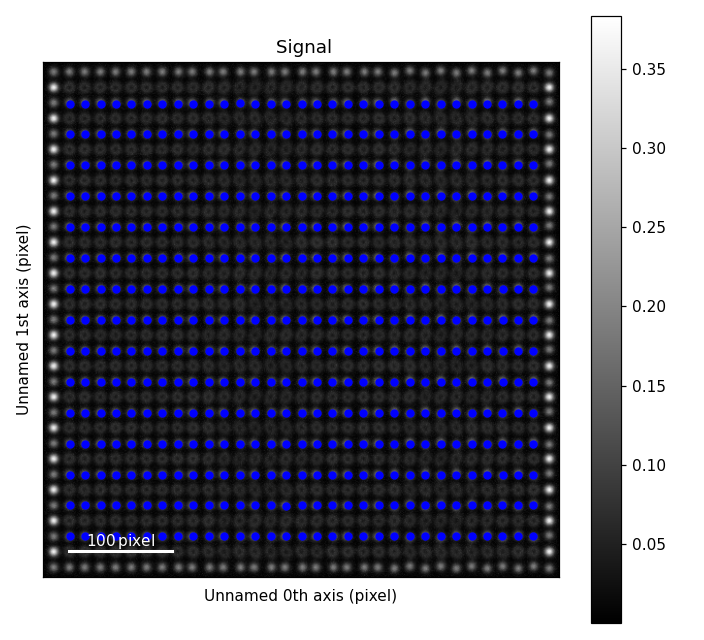

In [23]:
# create second sublattice and plot it
sublattice2 = am.Sublattice(positions2, image_atoms_subtracted, color='blue')
sublattice2.plot()

And refine the positions

In [22]:
# refine the atomic positions for the second sublattice like done for the first
sublattice2.construct_zone_axes()
sublattice2.refine_atom_positions_using_center_of_mass()
sublattice2.refine_atom_positions_using_2d_gaussian()

Center of mass:   0%|          | 0/465 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/465 [00:00<?, ?it/s]

## The atom lattice object

Having made these two sublattices, we can combine them in an `Atom_Lattice` object

<IPython.core.display.Javascript object>


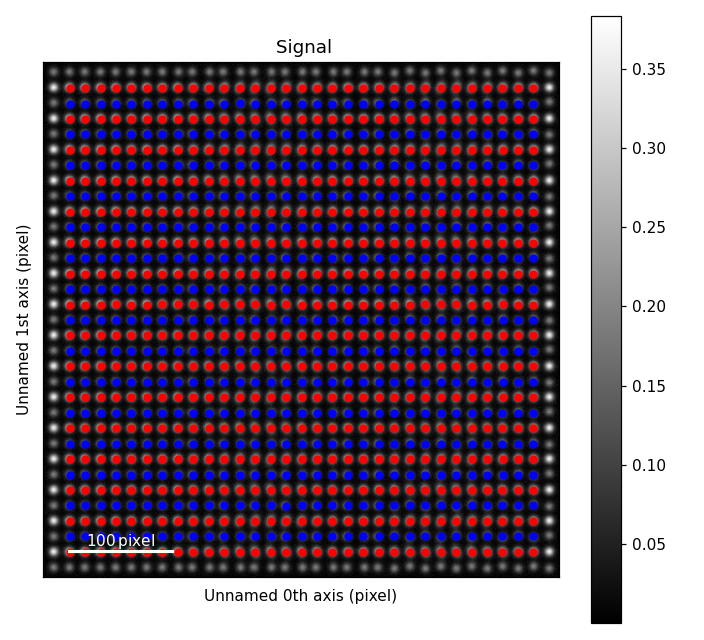

In [24]:
# combine the two sublattices into a single Atom_Lattice and plot the result
atom_lattice = am.Atom_Lattice(image=s.data, name='fantasite', sublattice_list=[sublattice, sublattice2])
atom_lattice.plot()

Atom_Lattice objects can be stored, to avoid having to run the often slow fitting routines several times.

In [25]:
# example of saving the atom lattice to disk
atom_lattice.save(overwrite=True)

Which can be restored:

In [26]:
# example of loading an atom lattice from disk
atom_lattice2 = am.load_atom_lattice_from_hdf5("fantasite_atom_lattice.hdf5")

## Analysing the structure

The sublattice object contains many utility functions for visualizing various structural effects.

For example, the distance between the atoms.

<IPython.core.display.Javascript object>


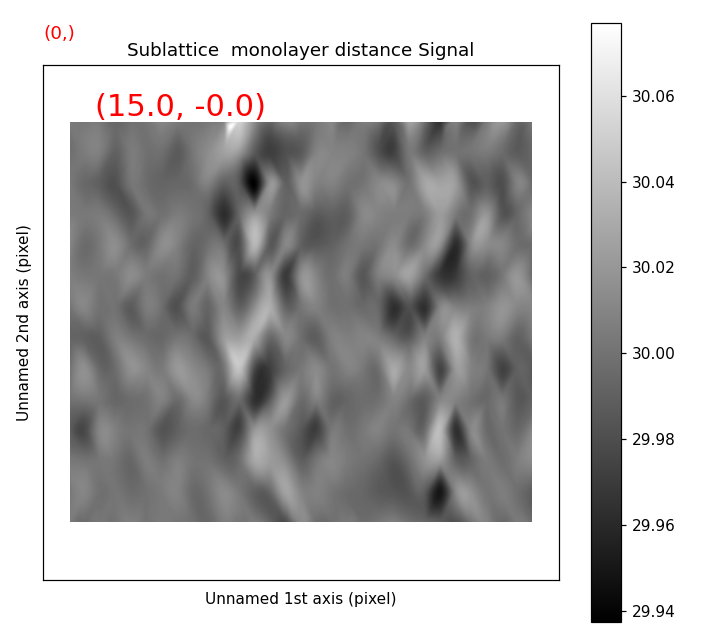

In [29]:
sublattice2.construct_zone_axes()
# get the distance between monolayers in the sublattice (may need to re-construct zone axes first)
s_monolayer = sublattice2.get_monolayer_distance_map()

# plot the result
s_monolayer.plot(navigator='slider')

Or the variations in distance between the atoms:

<IPython.core.display.Javascript object>


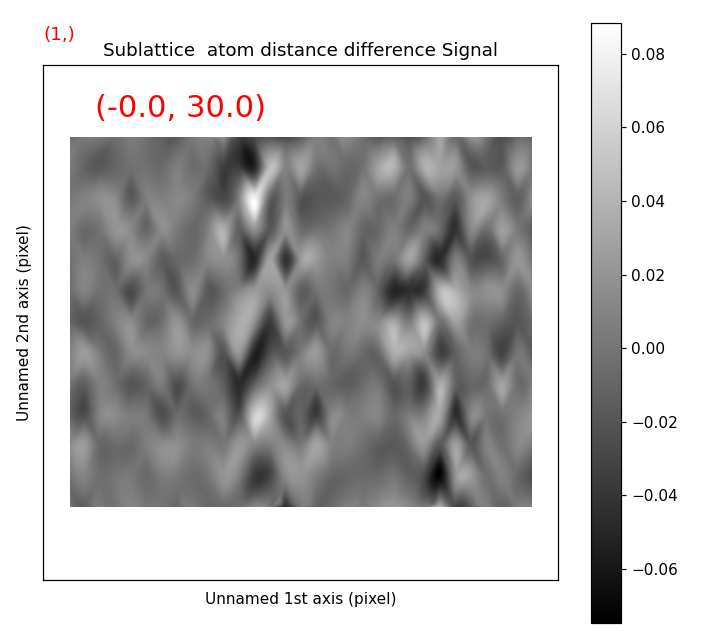

In [31]:
# calculate and plot the variation in distance between atoms
s_distance_difference = sublattice2.get_atom_distance_difference_map()
s_distance_difference.plot(navigator='slider')

Or the ellipticity of the atoms, which can be used to extract information about the structure parallel to the electron beam. Plotting only the magnitude:

<IPython.core.display.Javascript object>


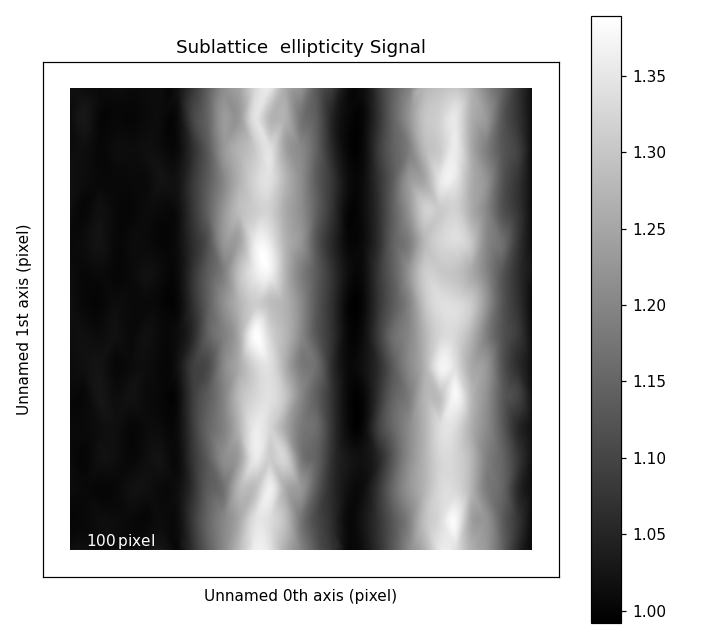

In [33]:
# calculate and plot the ellipticity of the signal
s_elli = sublattice.get_ellipticity_map()
s_elli.plot()

Plotting both the magnitude, and the direction:

<IPython.core.display.Javascript object>


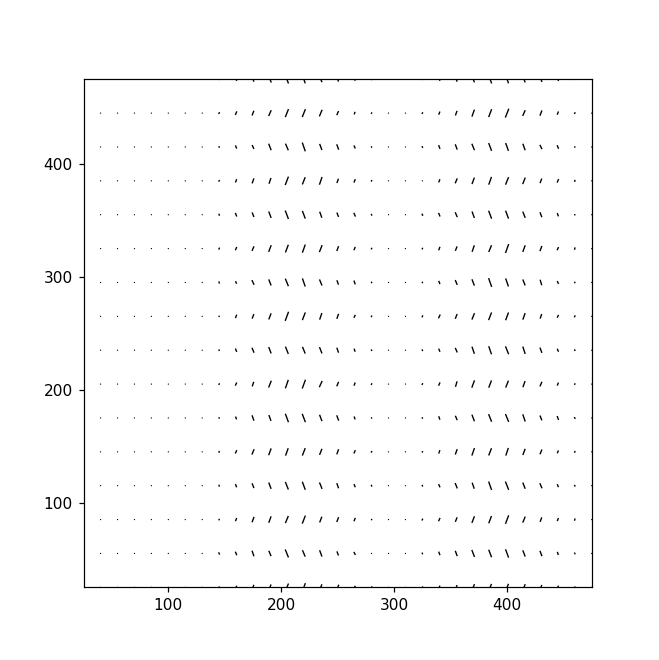

In [34]:
# plot the ellipticity as vectors
sublattice.plot_ellipticity_vectors()

## Integrating intensity

The intensity of the atomic columns can be found using `integrate_column_intensity` function, which supports two different methods: `Watershed` and `Voronoi`, where the latter is the default one.

Calculating Voronoi:   0%|          | 0/250000 [00:00<?, ?it/s]

Integrating:   0%|          | 0/961 [00:00<?, ?it/s]

Building intensity map:   0%|          | 0/250000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


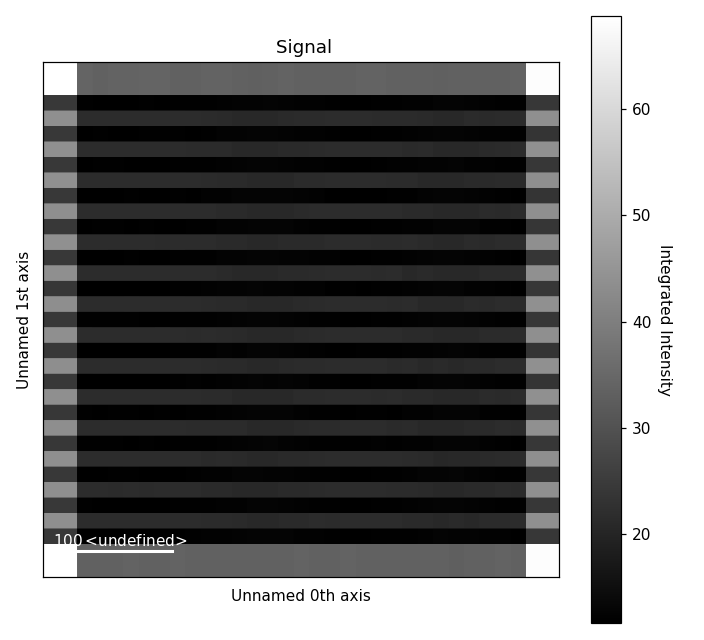

In [35]:
# integrate the atomic column intensity parallel to the beam and plot the result
i_points, i_record, p_record = atom_lattice.integrate_column_intensity()
i_record.plot()

This also works for sublattices directly. Since the fantasite dataset contain several sublattices, the results here will contain intensity from several columns. So for situation like this, the `atom_lattice.integrate_column_intensity` should be used.

Calculating Voronoi:   0%|          | 0/250000 [00:00<?, ?it/s]

Integrating:   0%|          | 0/496 [00:00<?, ?it/s]

Building intensity map:   0%|          | 0/250000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


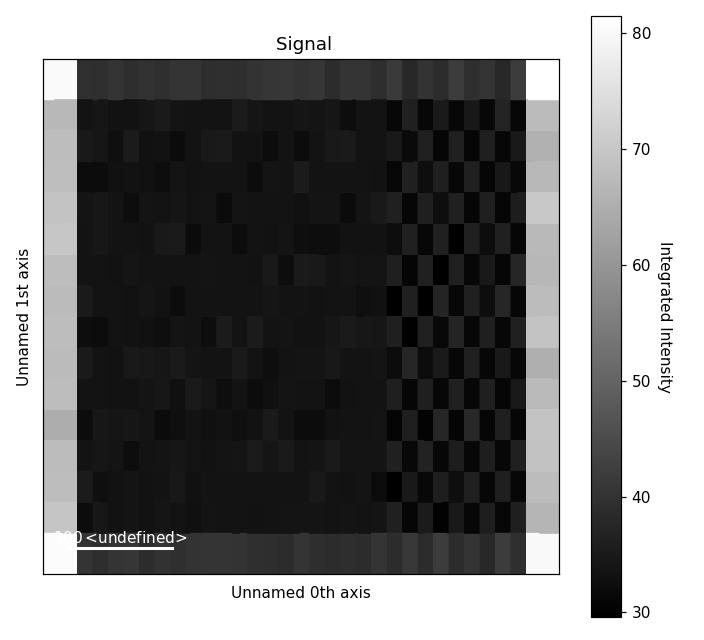

In [36]:
# do the same thing but just for the first sublattice
i_points, i_record, p_record = sublattice.integrate_column_intensity()
i_record.plot()

## Line profiles

All these structural properties can also be plotted as line profiles, as a function of distance from some atomic plane. For example the distance between the atoms in the horizontal direction.

This requires two things: 1) the zone axis perpendicular to the horizontal direction, and 2) some atomic plane perpendicular to the horizontal direction.

The former is found using `plot_planes`

<IPython.core.display.Javascript object>


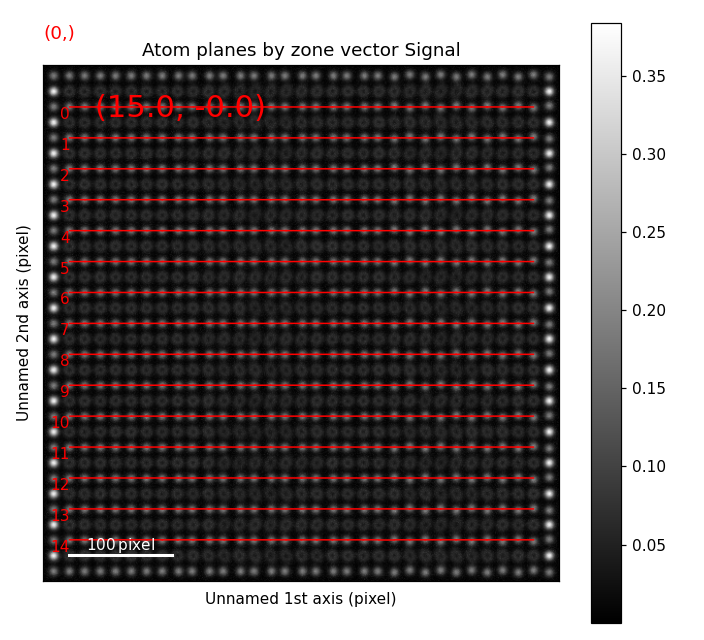

In [38]:
# plot the atomic planes of the second sublattice
sublattice2.plot_planes(navigator='slider')

Which shows that the second zone axis is the one perpendicular to the horisontal axis. Which we get from `zones_axis_average_distances`. Note that Python is zero-indexed, meaning we need to get index `1`

In [39]:
# extract the average distances in the perpendicular zone axis
zone = sublattice2.zones_axis_average_distances[1]

Then we extract an atomic plane which is also perpendicular to the horizontal axis

In [40]:
# extract a single atomic plan perpendicular to the horizontal axis
plane = sublattice2.atom_planes_by_zone_vector[zone][10]

Lastly, we get the line profile:

<IPython.core.display.Javascript object>


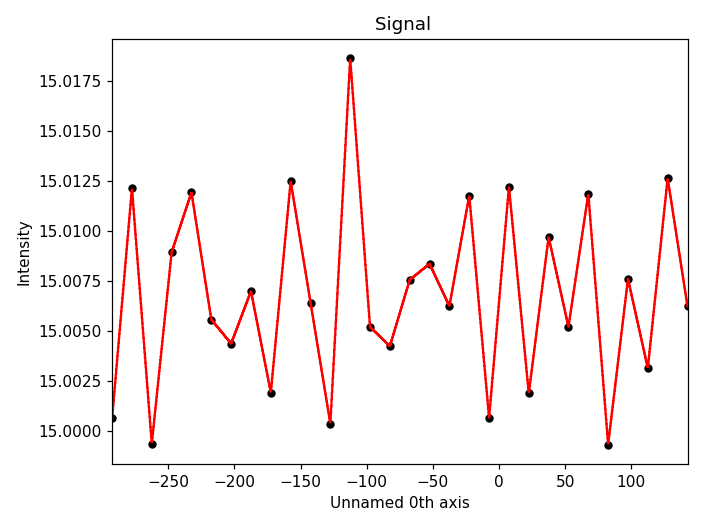

In [41]:
# Get line insensity profile and plot
s_monolayer_line = sublattice2.get_monolayer_distance_line_profile(zone_vector=zone, atom_plane=plane)
s_monolayer_line.plot()

This can be done for other properties as well:

<IPython.core.display.Javascript object>


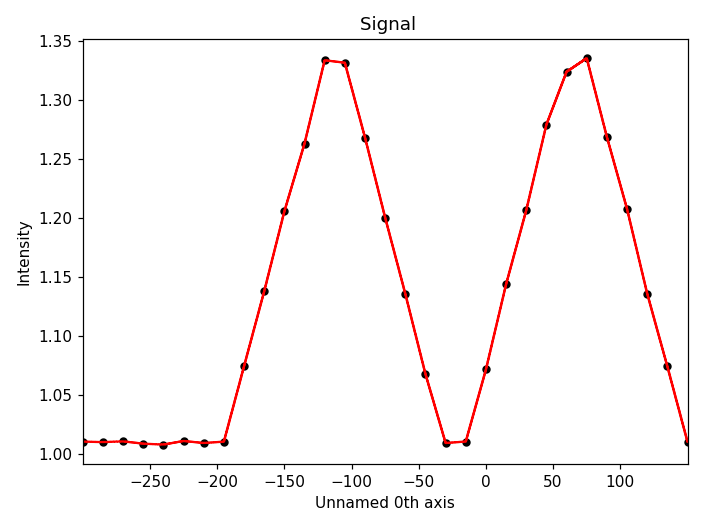

In [42]:
# do the same thing for ellipticity
s_elli_line = sublattice.get_ellipticity_line_profile(atom_plane=plane)
s_elli_line.plot()

## Properties

The atomic positions can be accessed directly as well

In [43]:
# display the first sublattice's 'x_position' attribute 
sublattice.x_position

array([ 55.00328077,  40.00674672, 115.00833162,  85.00247469,
       100.01100908, 114.96969646,  39.99921986, 474.99885006,
        99.98604738, 475.00687245, 129.98964582,  39.99553403,
       129.99358463, 115.00438502,  54.99450021,  24.99577492,
       115.00043532,  24.9969305 , 309.99118325, 309.9977112 ,
        84.99901624,  69.99618036,  69.98249451,  85.00045102,
        85.00406749, 114.99511415,  25.00161992,  55.00001007,
        39.99510157,  25.00802851,  39.9822866 ,  39.98506972,
        69.97844794,  40.01040031,  69.99699148, 114.99806342,
        69.9994111 , 129.98713189,  25.00997629, 100.02697141,
       100.00464151,  40.00348258, 129.99857774, 474.99190645,
       115.02630908, 129.99243024, 310.02113467, 309.98948474,
        25.01471131, 309.98895181, 100.0083482 ,  70.00221625,
        39.98922578, 475.00316817, 115.00436017, 130.01601514,
        25.01080605,  69.98876445,  84.99480045, 130.03553735,
       130.00028463, 474.99526711, 294.99366663,  55.00

These properites include: `y_position`, `sigma_x`, `sigma_y`, `ellipticity`, `rotation_ellipticity`.

These can be visualized using a variety of methods in the `sublattice` object, or stored to (for example) a csv-file which can be opened in spreadsheet software

In [44]:
# example saving sublattice attributes  
import numpy as np
np.savetxt("datafile.csv", (sublattice.x_position,
                            sublattice.y_position,
                            sublattice.sigma_x,
                            sublattice.sigma_y,
                            sublattice.ellipticity),
           delimiter=',')

The easiest way to save the monolayer map from earlier is through the HyperSpy HDF5 format

In [45]:
# example saving the monolayer map as a HypseSpy signal
s_monolayer.inav[0].save("monolayer_distance_map0.hspy", overwrite=True)

These signals can also be saved as tif, so they can be opened in other image viewers. For this to work, we must first change NaN values to zero:

In [46]:
# convert NaN values to zero using NumPy
import numpy as np
s_monolayer.data = np.nan_to_num(s_monolayer.data)

This file can be opened in image viewers such as ImageJ or Digital Micrograph

In [47]:
# save monolayer map as a tif
s_monolayer.save("monolayer_distance_map0.tif", overwrite=True)

## Determining polarization

In many ferroelectric materials, the spontaneous electric polarization can be determined by looking at the shift of some atomic columns in relation to the others. One example of this is in the ferroelectric perovskite oxides, where the B-cation is shifted from its cubic centrosymmetric position. The polarization can be determined by finding both the direction and magnitude of this shift.

Firstly, we get an appropriate artificial dataset, resembling a ferroelectric thin film grown on top of a non-ferroelectric substrate.

<IPython.core.display.Javascript object>


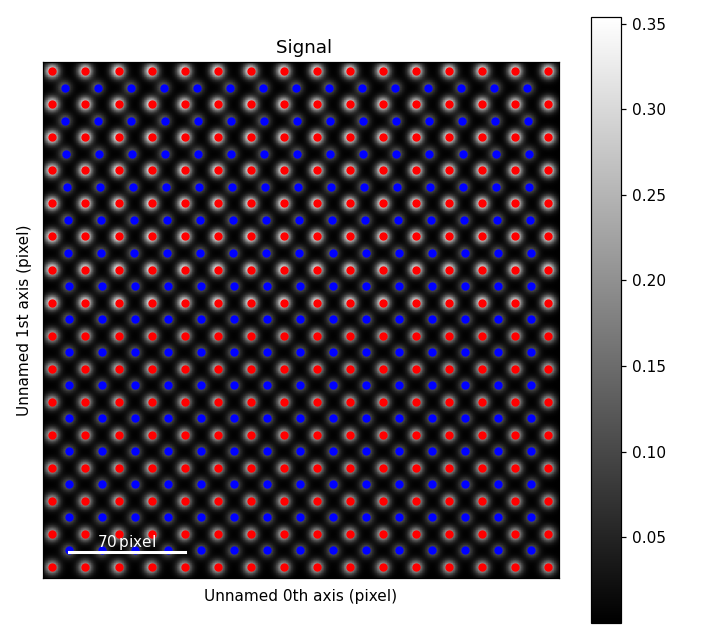

In [48]:
# open the polarization dummy data
atom_lattice = am.dummy_data.get_polarization_film_atom_lattice()
# plot the signal and notice the atom lattice is already defined 
atom_lattice.plot()

The blue, B-cation, atom columns in the top part of the image are shifted towards the left. By finding the centre position of four neighboring red A-cation forming a square, this shift can be quantified.

Finding these neighbors relies on moving along two zone axis directions in the A-cation sublattice.

In [49]:
# construct zone axes in one of the cation sublattices
sublatticeA = atom_lattice.sublattice_list[0]
sublatticeA.construct_zone_axes()

Next, find the two perpendicular zone axes spanning this square. For the perovskite oxide 100 projection, this is most likely the two first ones.

<IPython.core.display.Javascript object>


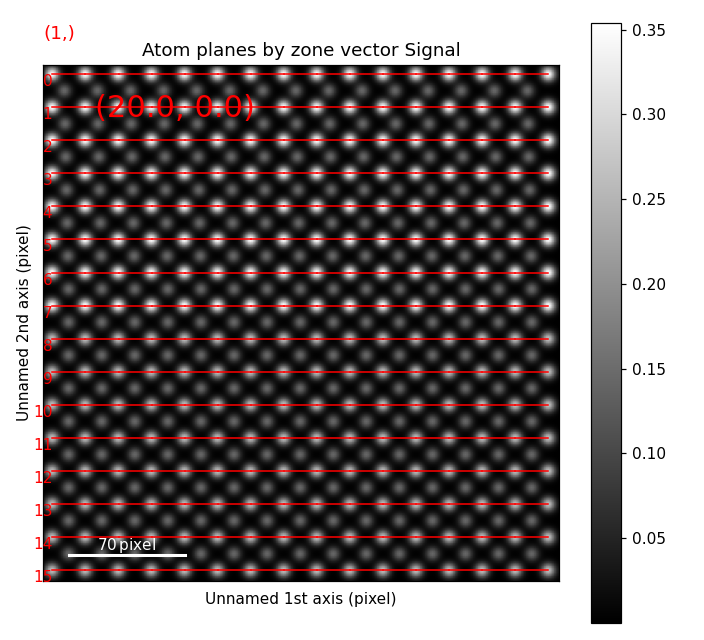

In [51]:
# use the plot_planes method to find perpendicular zone axes that represent the unit cell
sublatticeA.plot_planes(navigator='slider')

The zone axes are then used with the B-cation sublattice:

In [52]:
# calculate average distances on the sublattices
za0 = sublatticeA.zones_axis_average_distances[0]
za1 = sublatticeA.zones_axis_average_distances[1]
sublatticeB = atom_lattice.sublattice_list[1]

# compute the polarization from the second sublattice
s_polarization = sublatticeA.get_polarization_from_second_sublattice(za0, za1, sublatticeB)

This can be visualized directly by using the ``plot`` method, and the data itself can be accessed in the signal’s metadata.

<IPython.core.display.Javascript object>


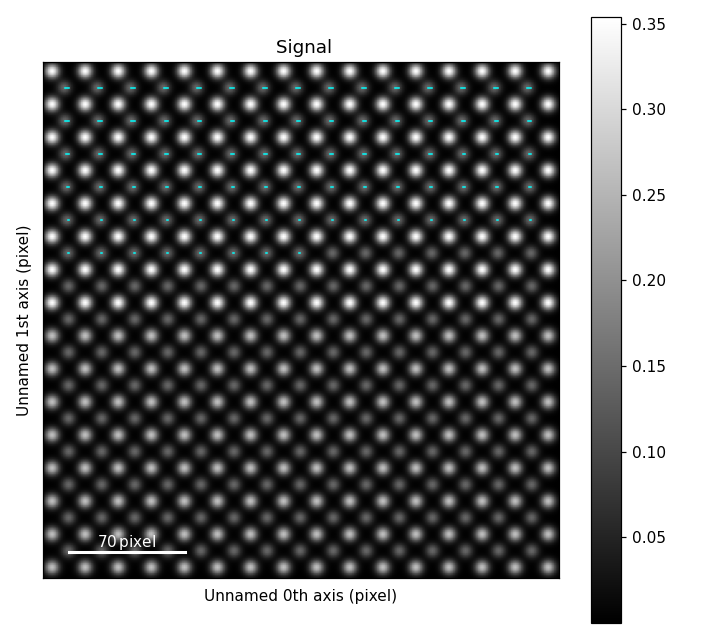

In [53]:
# visualize the polarization and save the polarization values to a new variable
s_polarization.plot()
vector_list = s_polarization.metadata.vector_list